Humans need to communicate. Out of this basic need of the human condition, a vast amount of written text has been generated on an everyday basis. Given rich text in social media, chat apps, emails, product reviews, news articles, research papers, and books, it becomes vital to enbale computers to understand them to offer assistance or make decisions based on human languages.

Natural language processing studies interactions between computers and humans using natural languages. In practice, it is very common to use natural language processing techniques to process and analyze text data.

To understand text, we can begin by learning its representation. Leveraging the existing text sequences from large corpora, self-supervised learning has been extensively used to pretrain text representations, such as by predicting some hidden part of the text using some other part of their surrounding text. In this way, models learn through supervision from massive text data without expensive labeling efforts.

As we will see in this chapter, when treating each word or subword as an individual token, the representation of each token can be pretrained using word2vec, GloVe, or subword embedding models on large corpora. After pretraining, representation of each token can be a vector, however, it remains the same no matter what the context is. For instance, the vector representation of "bank" is the same in both "go to the bank to deposit some money" and "go to the bank to sit down". Thus, many more recent pretraining models adapt representation of the same token to different contexts. Among them is BERT, a much deeper self-supervised model based on the Transformer encoder. In this chapter, we will focus on how to pretrain such representations for text, as highlighted in the following figure.

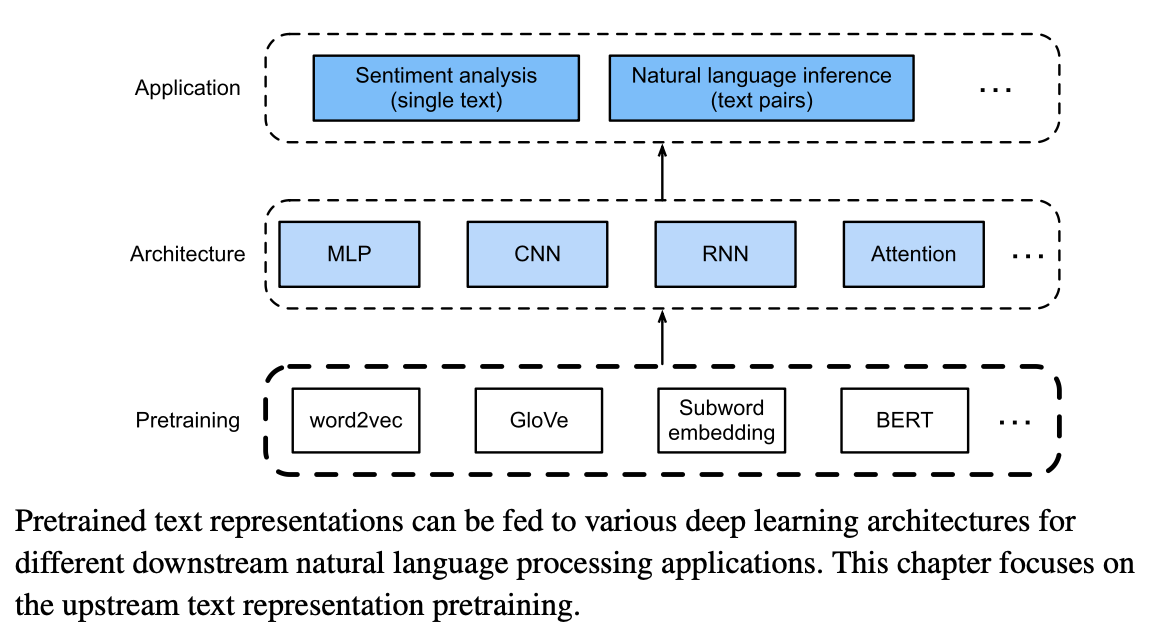

# 15.1 Word Embedding (word2vec)

Natural language is a complex system used to express meanings. In this system, words are the basic unit of the meaning. As the name implies, word vectors are vectors used to represent words, and can also be considered as feature vectors or representations of words. The technique of mapping words to real vectors is called word embedding. In recent years, word embedding has gradually become the basic knowledge of natural language processing.

## 15.5.1 One-Hot Vectors Are a Bad Choice

Although one-hot vectors are easy to construct, they are usually not a good choice. A main reason is that one-hot word vectors cannot accurately express the similarity between different words, such as the cosine similarity that we often use. For vectors $ \mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their cosine similarity is the cosine of the angle between them:

$$
\cfrac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|} \in [-1, 1]
$$

Since the cosine similarity between one-hot vectors of any two different words is 0, one-hot vectors cannot encode similarities among words.

## 15.1.2 Self-Supervised word2vec

The word2vec tool was proposed to address the above issue. It maps each word to a fixed-length vector, and these vectors can better express the similarity and analogy relationship among different words. The word2vec tool contains two models, namely skip-gram and continuous bag of words (CBOW). For semantically meaningful representations, their training relies on conditional probabilities that can be viewed as predicting some words using some of their surrounding words in corpora. Since supervision comes from the data without labels, both skip-gram and CBOW are self-supervised models.

## 15.1.3 The Skip-Gram Model

The skip-gram model assumes that a word can be used to generate its surrounding words in a text sequence. Take the text sequence "the", "man", "lovew", "his", "son" as an example. Let's choose "loves" as the center word "loves", the skip-gram model considers the conditional probability for generating the context words: "the", "man", "his", and "son", which are no more than 2 words away from the center word:

$$
P(\text{the, man, his, son | loves})
$$

Assume that the context words are independently generated given the center word (i.e., conditional independence). In this case, the above conditional probability can be rewritten as:

$$
P(\text{the | loves}) P(\text{man | loves}) P(\text{his | loves})  P(\text{son | loves}) 
$$

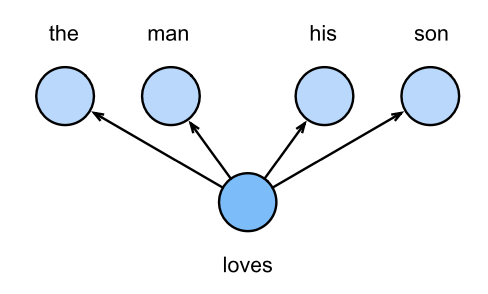

In the skip-gram model, each word has two $d$-dimensional-vector representations for calculating conditional probabilities. More concretely, for any word with index $i$ in the dictionary, denote by $\mathbf{v}_i \in \mathbb{R}^d$ and $\mathbf{u}_i \in \mathbb{R}^d$ its two vectors when used as a center word and a context word, respectively. The conditional probability of generating any context word $w_o$ (with index $o$ in the dictionary) given the center word $w_c$ (with index $c$ in the dictionary) can be modeled by a softma operation on vector dot products:

$$
P(w_o | w_c) = \cfrac{exp(\mathbf{u}_o^T \mathbf{v}_c)}{\sum_{i \in \mathcal{V}} exp(\mathbf{u_i}^T \mathbf{v}_c)}
$$

where the vocabulary index set $\mathcal{V} = \{0, 1, ..., |\mathcal{V}| - 1\}$. Given a text sequence of length $T$, where the word at time step $t$ is denoted $w^{(t)}$. Assume that context words are independently generated given any center word. For context window size $m$, the likelihood function of the skip-gram model is the probability of generating all context words given any center word:

$$
\prod_{t=1}^T \prod_{-m \leq j \leq m, j \not= 0} P(w^{(t+j)}| w^{(t)})
$$

where any time step is less than 1 or grater than $T$ can be omitted.

### Training

The skip-gram model parameters are the center word vector and context word vector for each word int he vocabulary. In training, we learn the model parameters by maximizing the likelihood function (i.e., maximum likelihood estimation). This is equivalent to minimizing the following loss function:

$$
- \sum_{t=1}^T \sum_{-m \leq j \leq m, j \not= 0} log P(w^{(t+j)}| w^{(t)})
$$

When using SGD to minimize the loss, in each iteration we can randomly sample a shorter subsequence to calculate the SGD for this subsequence to update the model parameters. To calculate this SGD, we need to obtain the gradients of the log conditional probability w.r.t. the center word vector and the context word vector. In general, the log conditional probability involving any pair of the center word $w_c$ and the context word $w_o$ is

$$
log P(w_o | w_c) = \mathbf{u_o}^T \mathbf{v_c} - log(\sum_{i \in \mathcal{V}} exp\left(\mathbf{u_i}^T \mathbf{v}_c\right))
$$

Through differentiation, we can obtain its gradient w.r.t. the center word vector $\mathbf{v}_c$ as

$$
\cfrac{\partial log P(w_o | w_c)}{\partial \mathbf{v}_c} = \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j | w_c) \mathbf{u}_j

$$

Note that the calculation requires the conditional probabilities of all words in the dictionary with $w_c$ as the center word. The gradients for the other word vectors can be obtained in the same way.

After training, for any word with index $i$ in the dictionary, we obtain both word vectors $\mathbf{v}_i$ and $mathbf{u}_i$. In NLP applications, the center word vectors of the skip-gram model are typically used as the word representations.

## 15.1.4 The Continuous Bag of Words (CBOW) Model

The continuous bag of words (CBOW) model is similar to the skip-gram model. The major difference from the skip-gram model is that the CBOW model assumes that a center word is generated based on its surrounding context words in the text sequence. For example, int he same text sequcne "the", "man", "lovew", "his", and "son", with "loves" as the center word and the context window size being 2, the CBOW model considers the conditional probability of generating the center word "loves" based on the conext words "the", "man", "his" and "son" which is

$$

P(\text{loves | the, man, his, son})

$$


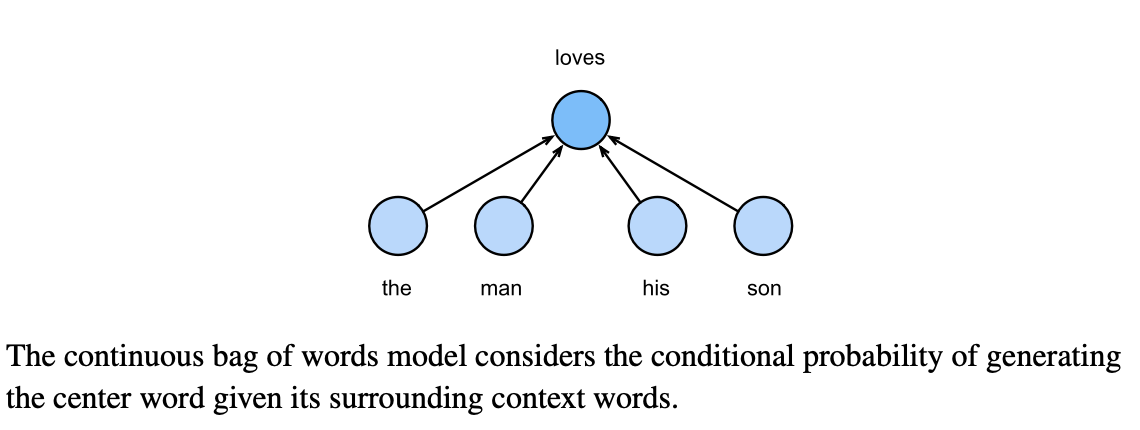

Since there are multiple context words in CBOW model, these context word vectors are averaged in the calculation of the conditional probability. Specifically, for any word with index $i$ in the dictionary, denote by $\mathbf{v}_i \in \mathbb{R}^d$ and $\mathbf{u}_i \in \mathbb{R}^d$ its two vectors when used as a context word and a center word respectively. The conditional probability of generating any center word $w_c$ given its surrounding context $w_{o_1}, w_{o_2}, ..., w_{o_{2m}}$ can be modeled by:

$$

P(w_c | w_{o_1}, ..., w_{o_{2m}}) = \cfrac{exp(\frac{1}{2m} \mathbf{u_c}^T (\mathbf{v_{o_1}} + ... + \mathbf{v_{o_{2m}}}))}{\sum_{i \in \mathcal{V}} exp(\frac{1}{2m} \mathbf{u_i}^T (\mathbf{v_{o_1}} + ... + \mathbf{v_{o_{2m}}}))}

$$

For brevity, let $\mathcal{W}_o = \{w_{o_1}, ..., w_{o_{2m}}\}$ and $\bar{v_o} = (\mathbf{v_{o_1}} + ... + \mathbf{v_{o_{2m}}}) / (2m) $. Then, above formula can be simplied as:

$$

P(w_c | \mathcal{W}_o) = \cfrac{exp(\mathbf{u_c}^T \bar{\mathbf{v_o}})}{\sum_{i \in \mathcal{V}} exp(\mathbf{u_i}^T \bar{\mathbf{v_o}})}

$$

Given a text sequence of length $T$, where the word at time step $t$ is denoted as $w^{(t)}$. For context window size $m$, the likelihood function of the CBOW model is the probability of generating all center words given their context words:


$$

\prod_{t=1}^T P(w^{(t)} | w^{(t-m)}, ..., w^{(t-1)}, w^{(t+1)}, ..., w^{(t+m)})


$$

### Training

Training CBOW models is almost the same as training skip-gram models. THE MLE of the CBOW model is equivalent to minimizing the following loss function:


$$

-\sum_{t=1}^T log P(w^{(t)} | w^{(t-m)}, ..., w^{(t-1)}, w^{(t+1)}, ..., w^{(t+m)})

$$

Through differentiation, we can obtain its gradient w.r.t. any context word vector $\mathbf{v}_{o_i}$ as 

$$

\cfrac{\partial log P(w_c | \mathcal{W}_o)}{ \partial \mathbf{v}_{o_i}} = \cfrac{1}{2m} \left( \mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j | \mathcal{W}_o) \mathbf{u}_j \right)

$$